In [1]:
from morfeus.conformer import ConformerEnsemble
from pathlib import Path
import stk
import pymongo
from morfeus import BuriedVolume, read_xyz
import os
from photocat_database.calculators.Optimise_ON import ETKDG_constaint
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:


def analyse_conformers_with_different_init(inchikey_photo_cat,
                                         db_mol_list):
    def get_conformers(inchikey_photo_cat,db_mol):
        
        collection = client[db_mol]['crest']
        data_crest = collection.find_one({"InChIKey":inchikey_photo_cat})
        original_path = "/media/mohammed/Work/Work/photo_switch/src/photocat_database"
        if data_crest is not None:
            crest_path = Path(original_path) / data_crest['crest_conformers']
            print(crest_path.exists())
            print('crest_path',data_crest['crest_conformers'])
            ce = ConformerEnsemble.from_crest(crest_path.parent)
            ce.sort()
            return ce
    ce_dict = {}
    for db_mol in db_mol_list:
        ce = get_conformers(inchikey_photo_cat,db_mol)

        ce_dict[db_mol] = ce

    return ce_dict
def add_buried_volume_of_h_in_ce(ce_dict,db_mol_list,inchikey_photo_cat):
    for db_mol in db_mol_list:
        ce = ce_dict[db_mol]
        if ce is not None:
            db_constructed = stk.ConstructedMoleculeMongoDb(
                client,
                database=db_mol,
            )
            constructed_molecule = db_constructed.get(
                {"InChIKey": inchikey_photo_cat}
            )
            display(constructed_molecule.to_rdkit_mol())
            calculator = ETKDG_constaint()
            oxygen_id, hydrogen_id = (
                calculator.get_atom_position_to_induce_constain_for_3bb(
                    constructed_molecule
                )
            )
            if len(hydrogen_id) < 2:
                oxygen_id, hydrogen_id = (
                    calculator.get_atom_position_to_induce_constain_for_4bb(
                        constructed_molecule
                    )
                )
            for conformer in ce:
                elements, coordinates = ce.elements, conformer.coordinates
                bv = BuriedVolume(elements, coordinates, hydrogen_id[0]+1)
                conformer.properties["buried_volume_H1"] = bv.fraction_buried_volume
                bv = BuriedVolume(elements, coordinates, hydrogen_id[1]+1)
                conformer.properties["buried_volume_H2"] = bv.fraction_buried_volume
    return ce_dict
def merge_dict (ce_dict_E,ce_dict_Z):
    ce_dict = {}
    for key in ce_dict_Z.keys():
        if ce_dict_Z[key] is not None:
            ce_dict[key] = ce_dict_Z[key]
    for key in ce_dict_E.keys():
        if ce_dict_E[key] is not None:
            ce_dict[key] = ce_dict_E[key]
    return ce_dict
def plot_hist_buried(ce_dict):
    number_of_plots = len(ce_dict)
    fig, ax = plt.subplots(2,number_of_plots//2,figsize=(15,10))
    ax = ax.flatten()
    for i, (db_mol,ce) in enumerate(ce_dict.items()):
        if ce is not None:
            boltzmann_weight = ce.boltzmann_weights()
            ax[i].hist(ce.get_properties()["buried_volume_H1"], bins=50, alpha=0.5, label='H1',weights=boltzmann_weight)
            ax[i].hist(ce.get_properties()["buried_volume_H2"], bins=50, alpha=0.5, label='H2',weights=boltzmann_weight)
            boltzmann_average_HI = ce.boltzmann_statistic("buried_volume_H1",temperature=300)
            print("boltzmann_average_H1",boltzmann_average_HI)
            boltzmann_average_HII = ce.boltzmann_statistic("buried_volume_H2",temperature=300)
            print("boltzmann_average_H2",boltzmann_average_HII)    
            ax[i].set_title(f"{db_mol},{boltzmann_average_HI:0.2f},{boltzmann_average_HII:0.2f}")
            ax[i].set_xlabel("Fraction buried volume of H")
            ax[i].set_xlim(0,1)
            ax[i].legend()
from photocat_database.calculators.Optimise_Constructed import ETKDG_isomer

from morfeus import geometry
import numpy as np
def calc_dihedral(atoms_id,coordinates):
    """ Calculate dihedral angle method. From bioPython.PDB
    (adapted to np.array)
    Calculate the dihedral angle between 4 vectors
    representing 4 connected points. The angle is in
    [-pi, pi].
    """
    atom_coordinates = []
    for atom in atoms_id:
        atom_coordinates.append(coordinates[atom])
    u1, u2, u3, u4 = atom_coordinates
    a1 = u2 - u1
    a2 = u3 - u2
    a3 = u4 - u3

    v1 = np.cross(a1, a2)
    v1 = v1 / (v1 * v1).sum(-1)**0.5
    v2 = np.cross(a2, a3)
    v2 = v2 / (v2 * v2).sum(-1)**0.5
    porm = np.sign((v1 * a3).sum(-1))
    rad = np.arccos((v1*v2).sum(-1) / ((v1**2).sum(-1) * (v2**2).sum(-1))**0.5)
    if not porm == 0:
        rad = rad * porm
    grad = rad * 180 / np.pi    
    return grad
def add_buried_NN_dihedral(ce_dict,db_mol_list,inchikey_photo_cat):
    for db_mol in db_mol_list:
        ce = ce_dict[db_mol]
        if ce is not None:
            calculator = ETKDG_isomer(isomers="E")
            db_constructed = stk.ConstructedMoleculeMongoDb(
                client,
                database=db_mol,
            )
            constructed_molecule = db_constructed.get(
                {"InChIKey": inchikey_photo_cat}
            )
            calculator = ETKDG_isomer(isomers="E")

            atoms_id ,mol= calculator.get_NNdoublebond_atoms(constructed_molecule)

            for conformer in ce:
                elements, coordinates = ce.elements, conformer.coordinates
                conformer.properties["NN_dihdral_angle"] = calc_dihedral(atoms_id,coordinates)

    return ce_dict
def plot_hist_NN_dihedral(ce_dict):
    number_of_plots = len(ce_dict)
    fig, ax = plt.subplots(2,number_of_plots//2,figsize=(15,10))
    ax = ax.flatten()
    for i, (db_mol,ce) in enumerate(ce_dict.items()):
        if ce is not None:
            boltzmann_weight = ce.boltzmann_weights()
            ax[i].hist(ce.get_properties()["NN_dihdral_angle"], bins=50, alpha=0.5, label='NN',weights=boltzmann_weight)
            ax[i].set_title(db_mol)
            ax[i].set_xlabel("NN Dihedral angle (degree)")
            ax[i].set_xlim(-200,200)
            ax[i].legend()

from photocat_database.calculators.Optimise_Constructed import ETKDG_isomer

from morfeus import geometry
import numpy as np

def add_HO_distances(ce_dict,db_mol_list,inchikey_photo_cat):
    for db_mol in db_mol_list:
        ce = ce_dict[db_mol]
        if ce is not None:
            calculator = ETKDG_isomer(isomers="E")
            db_constructed = stk.ConstructedMoleculeMongoDb(
                client,
                database=db_mol,
            )
            constructed_molecule = db_constructed.get(
                {"InChIKey": inchikey_photo_cat}
            )
            
            calculator = ETKDG_constaint()
            oxygen_id, hydrogen_id = (
                calculator.get_atom_position_to_induce_constain_for_3bb(
                    constructed_molecule
                )
            )
            if len(hydrogen_id) < 2:
                oxygen_id, hydrogen_id = (
                    calculator.get_atom_position_to_induce_constain_for_4bb(
                        constructed_molecule
                    )
                )
            for conformer in ce:
                elements, coordinates = ce.elements, conformer.coordinates
                distances = [ np.linalg.norm(coordinates[oxygen_i] - coordinates[hydrogen_i]) for oxygen_i, hydrogen_i in itertools.product(oxygen_id, hydrogen_id)]

                conformer.properties["HO_distances"] = distances

    return ce_dict
def plot_HO_distance(ce_dict):
    number_of_plots = len(ce_dict)
    fig, ax = plt.subplots(2,number_of_plots//2,figsize=(15,10))
    ax = ax.flatten()
    for i, (db_mol,ce) in enumerate(ce_dict.items()):
        if ce is not None:
            boltzmann_weight = ce.boltzmann_weights()
            for distribution in ce.get_properties()["HO_distances"].T:
                ax[i].hist(distribution, bins=10, alpha=0.5, label='NN',weights=boltzmann_weight)
            boltzmann_average = ce.boltzmann_statistic("HO_distances",temperature=300)
            print('boltzmann_average',boltzmann_average)
            title_string = f"{db_mol}"
            for bl in boltzmann_average:
                ax[i].axvline(x=bl, color='r', label='Boltzmann average')
                title_string += f",{bl:0.2f} "
            ax[i].set_title(title_string)
            ax[i].set_xlabel("H-O distance (A)")
            ax[i].set_xlim(0,20)
            ax[i].legend()

## case of a good molecule

True
crest_path data/constructed_photocat_E/Crest/UYBPBNGMIRHRMW-NVQSTNCTSA-N/crest_conformers.xyz
True
crest_path data/constructed_photocat_E_ON/Crest/UYBPBNGMIRHRMW-NVQSTNCTSA-N/crest_conformers.xyz


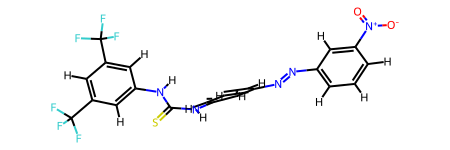

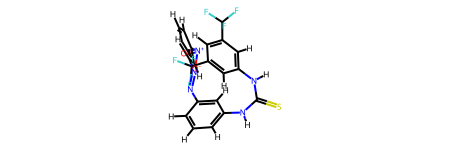

True
crest_path data/constructed_photocat_Z/Crest/UYBPBNGMIRHRMW-KTMFPKCZSA-N/crest_conformers.xyz
True
crest_path data/constructed_photocat_Z_ON/Crest/UYBPBNGMIRHRMW-KTMFPKCZSA-N/crest_conformers.xyz


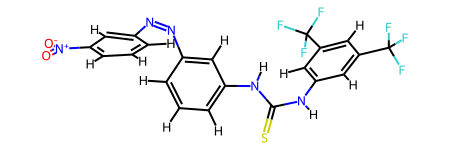

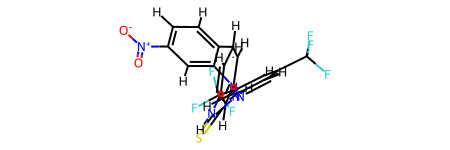

boltzmann_average_H1 0.49163831710916606
boltzmann_average_H2 0.595685159937094
boltzmann_average_H1 0.4684152255183193
boltzmann_average_H2 0.5746557751316844
boltzmann_average_H1 0.4672771787578421
boltzmann_average_H2 0.47320936259868573
boltzmann_average_H1 0.4675298042499659
boltzmann_average_H2 0.47466912473930345


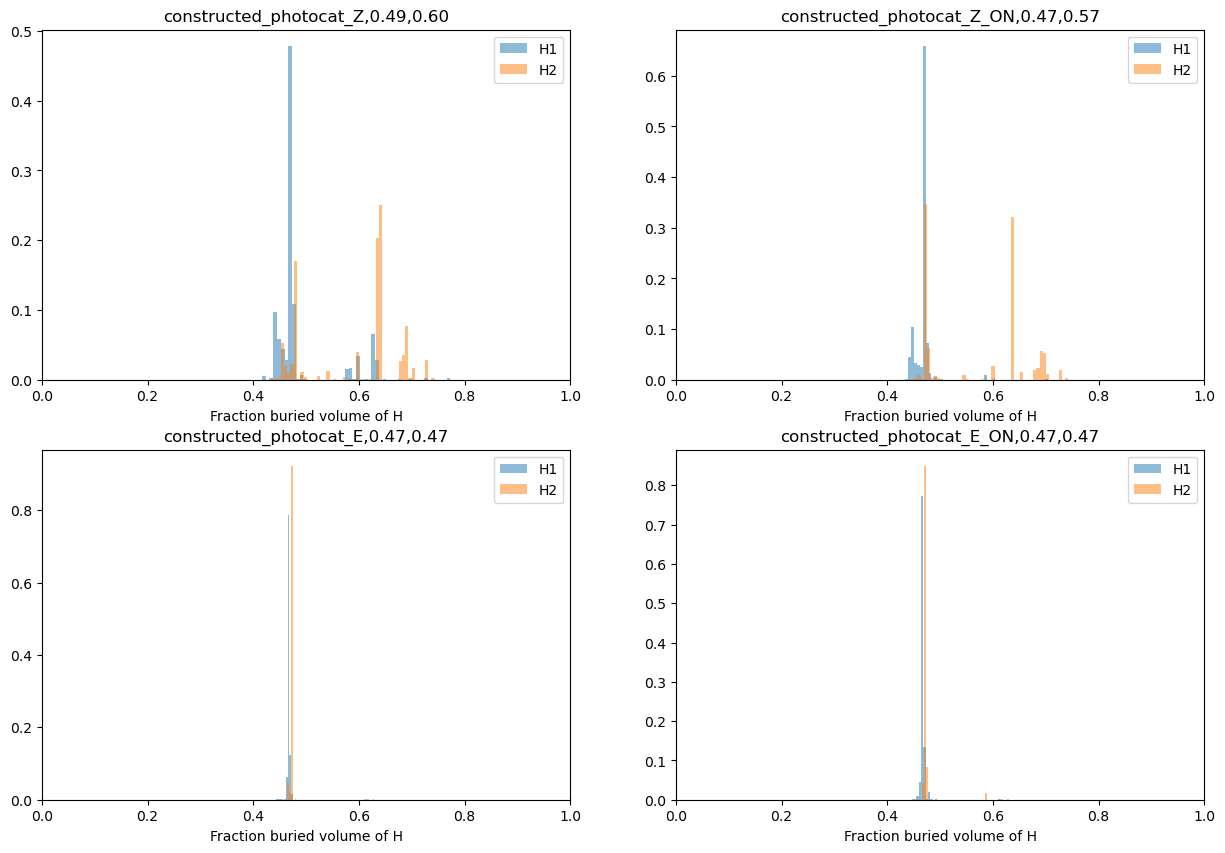

In [3]:
client = "mongodb://localhost:27017/"
client = pymongo.MongoClient(client)
inchikey_photo_cat_E = "UYBPBNGMIRHRMW-NVQSTNCTSA-N"
inchikey_photo_cat_Z = "UYBPBNGMIRHRMW-KTMFPKCZSA-N"
db_mol_list = ["constructed_photocat_Z","constructed_photocat_E","constructed_photocat_Z_ON","constructed_photocat_E_ON"]
ce_dict_E= analyse_conformers_with_different_init(inchikey_photo_cat_E,db_mol_list)
ce_dict_E = add_buried_volume_of_h_in_ce(ce_dict_E,db_mol_list,inchikey_photo_cat_E)
ce_dict_Z = analyse_conformers_with_different_init(inchikey_photo_cat_Z,db_mol_list)
ce_dict_Z = add_buried_volume_of_h_in_ce(ce_dict_Z,db_mol_list,inchikey_photo_cat_Z)
ce_dict = merge_dict(ce_dict_E,ce_dict_Z)
plot_hist_buried(ce_dict)

In [4]:

ce_dict_E = add_buried_NN_dihedral(ce_dict_E,db_mol_list,inchikey_photo_cat_E)
ce_dict_Z = add_buried_NN_dihedral(ce_dict_Z,db_mol_list,inchikey_photo_cat_Z)
plot_hist_NN_dihedral(ce_dict)


[36, 22, 23, 37]
[36, 22, 23, 37]
[36, 22, 23, 37]
[36, 22, 23, 37]


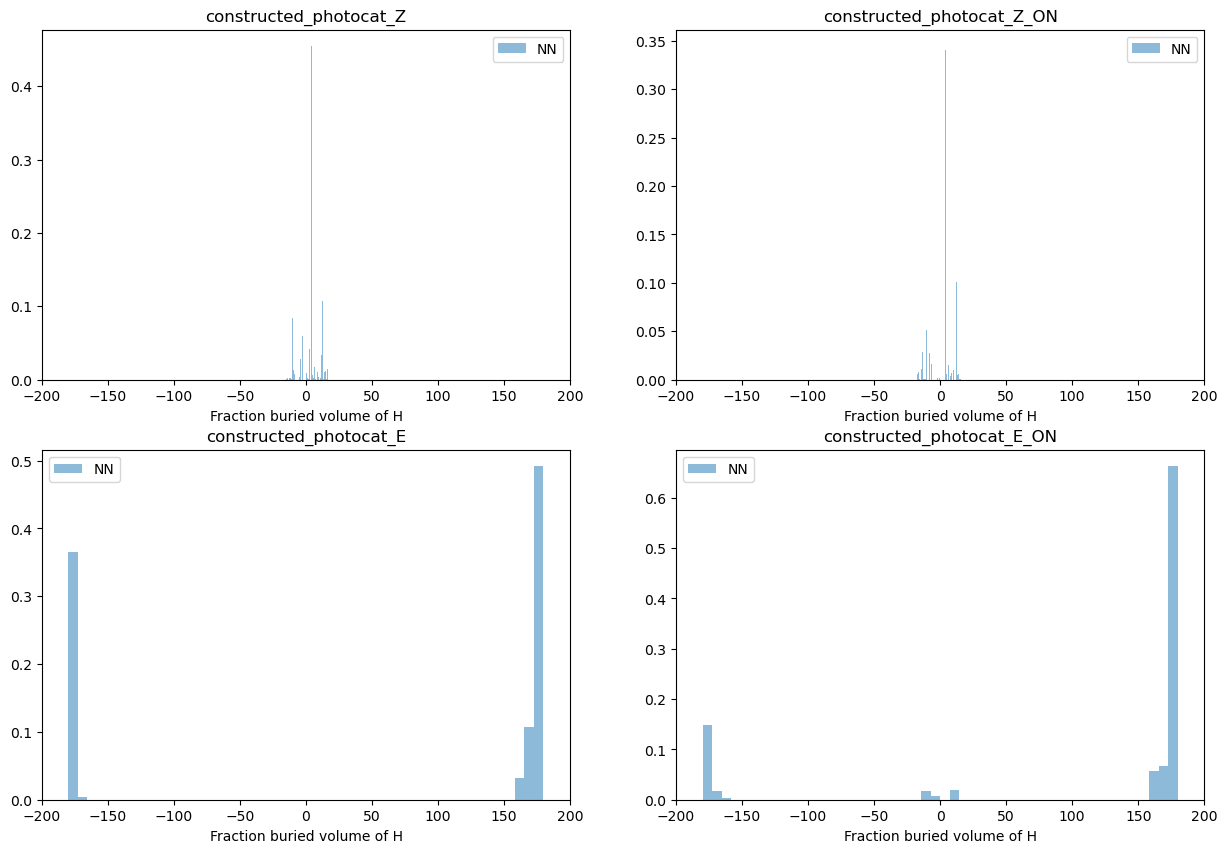

boltzmann_average [6.64314006 4.44733878 6.30965565 4.14734832]
boltzmann_average [7.14225219 5.20433098 7.87506395 6.11677506]
boltzmann_average [11.1329959   8.84554888  9.75913442  7.58002376]
boltzmann_average [10.4402447   8.80044315 10.42016351  8.73234317]


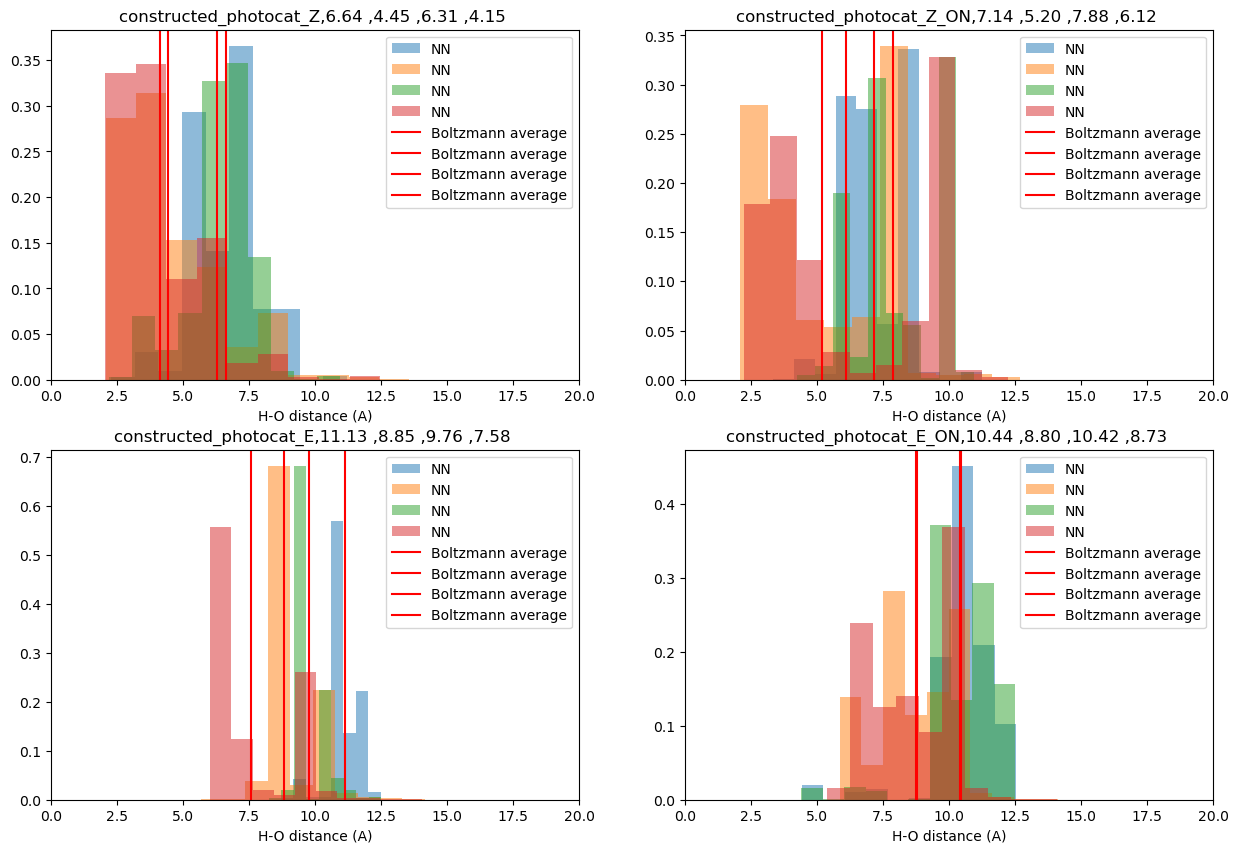

In [6]:

ce_dict_E = add_HO_distances(ce_dict_E,db_mol_list,inchikey_photo_cat_E)
ce_dict_Z = add_HO_distances(ce_dict_Z,db_mol_list,inchikey_photo_cat_Z)
plot_HO_distance(ce_dict)




# random constructed molecule

True
crest_path data/crest/constructed_photocat_Z/Crest/NIQMVQOWZBGKJJ-BZZOAKBMSA-N/crest_conformers.xyz
True
crest_path data/crest/constructed_photocat_E/Crest/NIQMVQOWZBGKJJ-BZZOAKBMSA-N/crest_conformers.xyz
True
crest_path data/crest/constructed_photocat_Z_ON/Crest/NIQMVQOWZBGKJJ-BZZOAKBMSA-N/crest_conformers.xyz
True
crest_path data/crest/constructed_photocat_E_ON/Crest/NIQMVQOWZBGKJJ-BZZOAKBMSA-N/crest_conformers.xyz


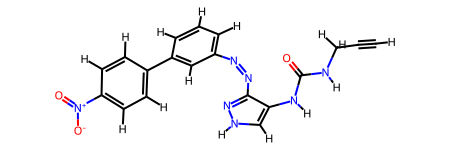

 no substructure found
 no substructure found


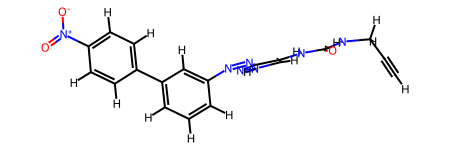

 no substructure found
 no substructure found


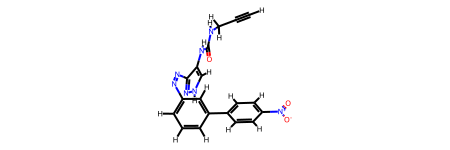

 no substructure found
 no substructure found


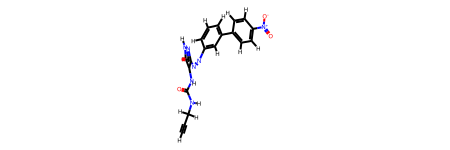

 no substructure found
 no substructure found
True
crest_path data/crest/constructed_photocat_Z/Crest/NIQMVQOWZBGKJJ-BZZOAKBMSA-N/crest_conformers.xyz
True
crest_path data/crest/constructed_photocat_E/Crest/NIQMVQOWZBGKJJ-BZZOAKBMSA-N/crest_conformers.xyz
True
crest_path data/crest/constructed_photocat_Z_ON/Crest/NIQMVQOWZBGKJJ-BZZOAKBMSA-N/crest_conformers.xyz
True
crest_path data/crest/constructed_photocat_E_ON/Crest/NIQMVQOWZBGKJJ-BZZOAKBMSA-N/crest_conformers.xyz


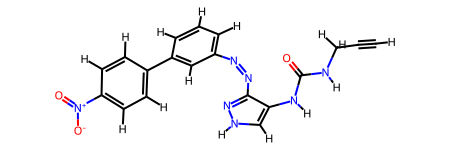

 no substructure found
 no substructure found


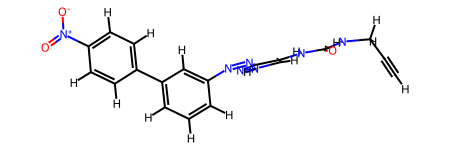

 no substructure found
 no substructure found


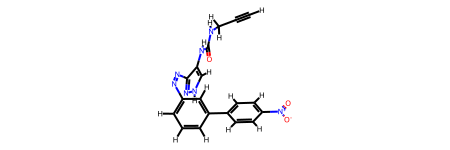

 no substructure found
 no substructure found


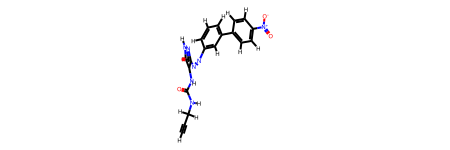

 no substructure found
 no substructure found
boltzmann_average_H1 0.4681642478468298
boltzmann_average_H2 0.4543010719869645
boltzmann_average_H1 0.46084184524644567
boltzmann_average_H2 0.4723700498539133
boltzmann_average_H1 0.4703999118521821
boltzmann_average_H2 0.46928445870439334
boltzmann_average_H1 0.44681331277906194
boltzmann_average_H2 0.4959330111443007


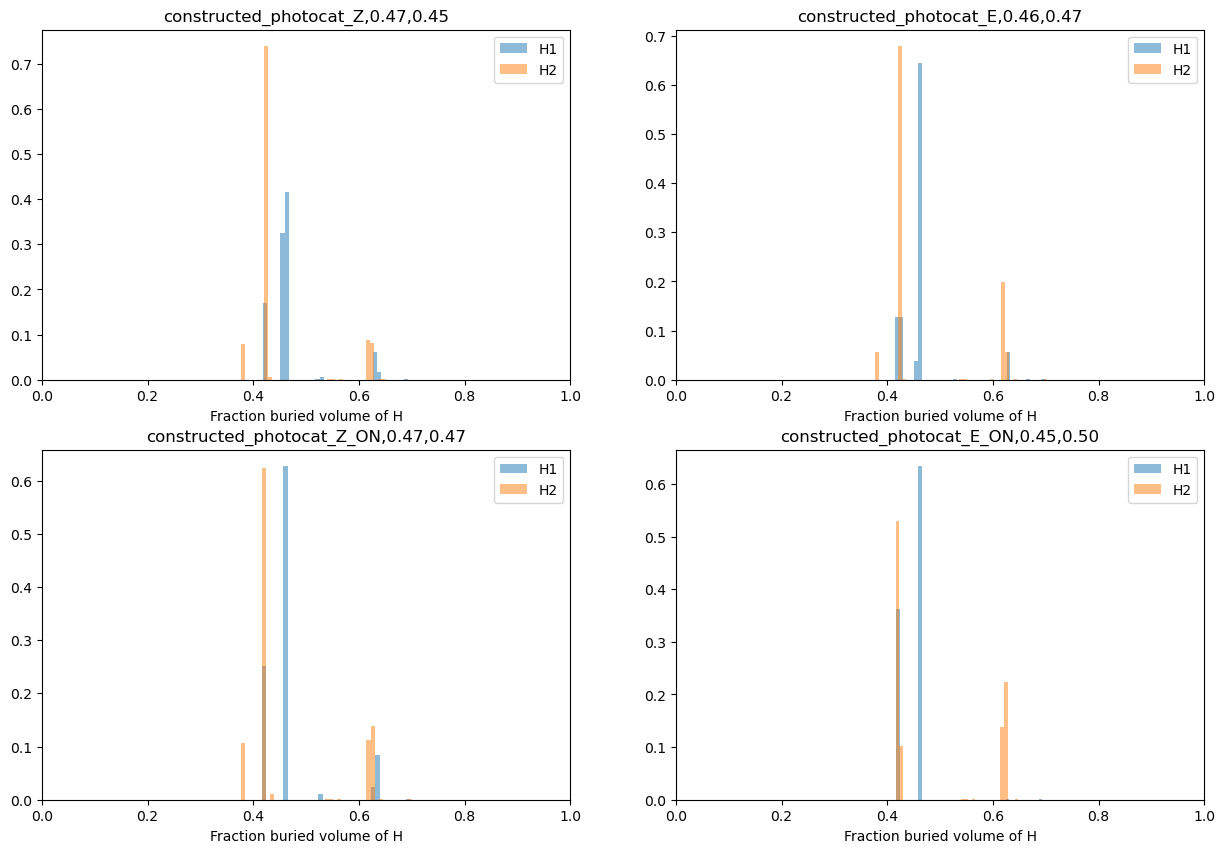

In [9]:

inchikey_photo_cat_E = "NIQMVQOWZBGKJJ-BZZOAKBMSA-N"
inchikey_photo_cat_Z = "NIQMVQOWZBGKJJ-BZZOAKBMSA-N"
ce_dict_E= analyse_conformers_with_different_init(inchikey_photo_cat_E,db_mol_list)
ce_dict_E = add_buried_volume_of_h_in_ce(ce_dict_E,db_mol_list,inchikey_photo_cat_E)
ce_dict_Z = analyse_conformers_with_different_init(inchikey_photo_cat_Z,db_mol_list)
ce_dict_Z = add_buried_volume_of_h_in_ce(ce_dict_Z,db_mol_list,inchikey_photo_cat_Z)
ce_dict = merge_dict(ce_dict_E,ce_dict_Z)
plot_hist_buried(ce_dict)

[24, 20, 21, 33]
[24, 20, 21, 33]
[24, 20, 21, 33]
[24, 20, 21, 33]
[24, 20, 21, 33]
[24, 20, 21, 33]
[24, 20, 21, 33]
[24, 20, 21, 33]


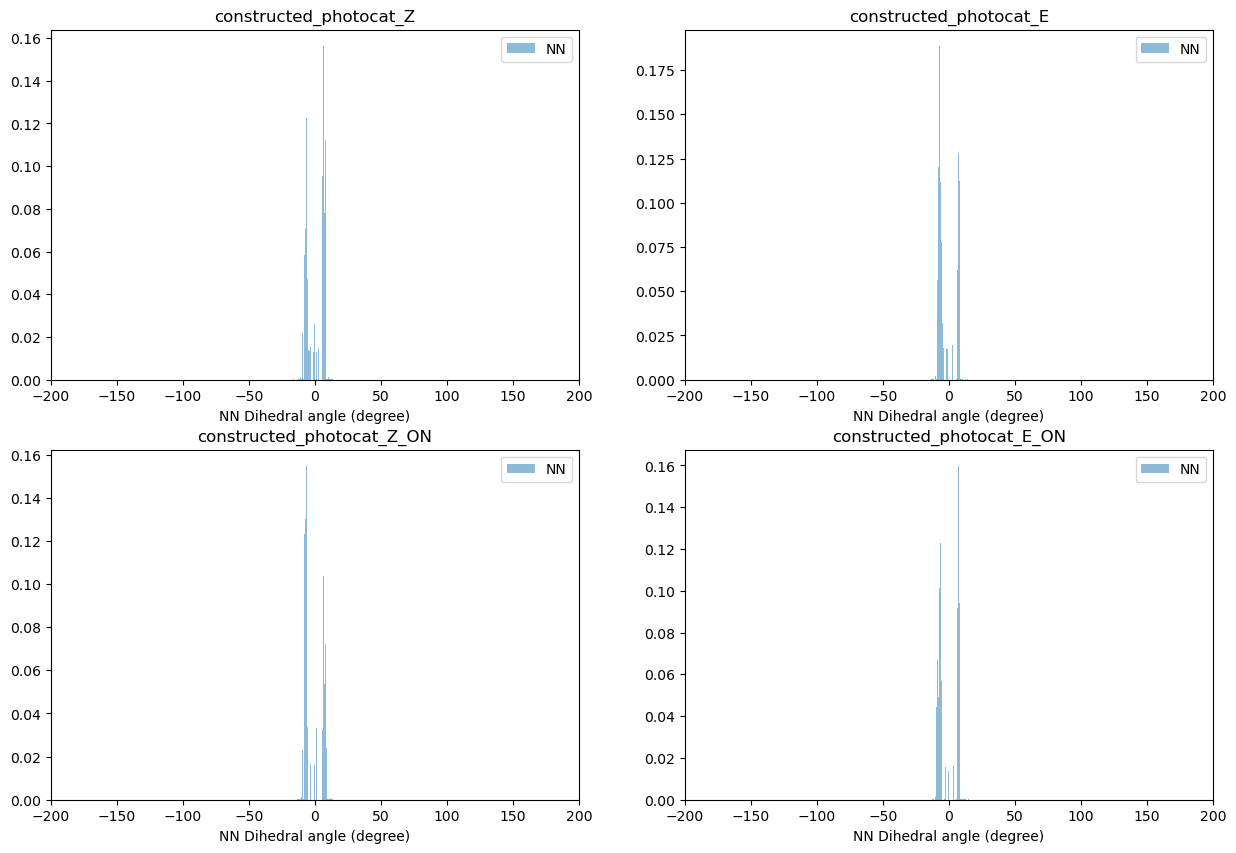

In [14]:

ce_dict_E = add_buried_NN_dihedral(ce_dict_E,db_mol_list,inchikey_photo_cat_E)
ce_dict_Z = add_buried_NN_dihedral(ce_dict_Z,db_mol_list,inchikey_photo_cat_Z)
plot_hist_NN_dihedral(ce_dict)


 no substructure found
 no substructure found
 no substructure found
 no substructure found
 no substructure found
 no substructure found
 no substructure found
 no substructure found
 no substructure found
 no substructure found
 no substructure found
 no substructure found
 no substructure found
 no substructure found
 no substructure found
 no substructure found
boltzmann_average [11.82577827 13.29220696 11.81632731 13.27052662]
boltzmann_average [11.94135379 13.10418312 11.67904973 12.85709498]
boltzmann_average [11.86960564 13.13113443 11.78705692 13.00005889]
boltzmann_average [11.96023283 12.75692888 11.93538152 12.75192329]


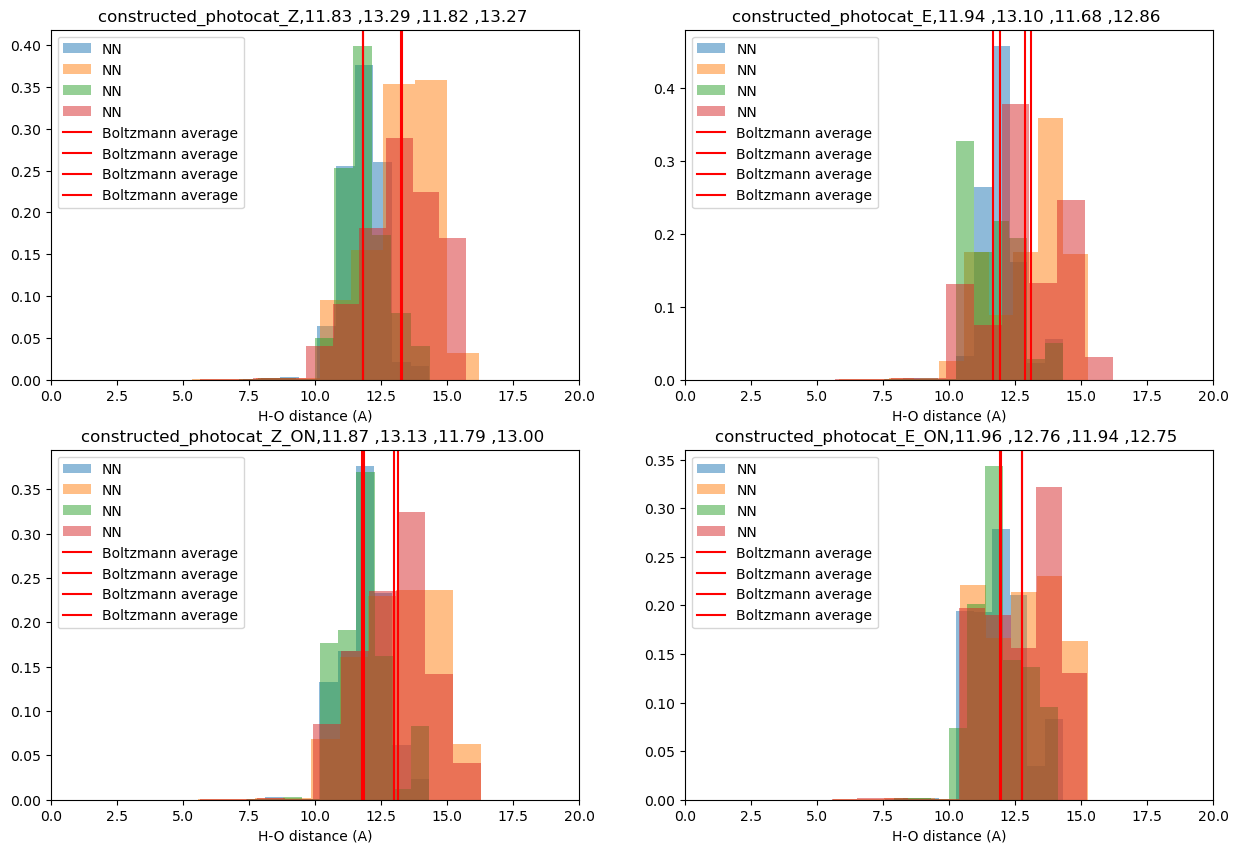

In [15]:

ce_dict_E = add_HO_distances(ce_dict_E,db_mol_list,inchikey_photo_cat_E)
ce_dict_Z = add_HO_distances(ce_dict_Z,db_mol_list,inchikey_photo_cat_Z)
plot_HO_distance(ce_dict)